# CIFAR-10 Image Classification using Convolutional Neural Networks in PyTorch

## 1. Introduction
The **CIFAR-10 dataset** consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class.  
- Training set: 50,000 images  
- Test set: 10,000 images  
- Classes: `airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck`  

In this notebook, we will:  
1. Load CIFAR-10 dataset from `torchvision`  
2. Build train and test dataloaders  
3. Visualize some sample images  
4. Create a custom CNN model with regularization and normalization  
5. Define loss function and optimizer  
6. Train the model  
7. Evaluate performance on the test set  
8. Show misclassified examples  
9. Save the trained model
10. Load the saved model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## 2. Load CIFAR-10 Dataset
We will use `torchvision.datasets.CIFAR10` and apply transformations:
- Convert to tensor
- Normalize pixel values (mean & std for CIFAR-10)

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean
                         (0.2023, 0.1994, 0.2010))  # std
])

# Load train and test dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                          shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### Note

**What are the mean and std values?**

Those values are the per-channel mean and standard deviation of the CIFAR-10 training set. They’re commonly used for normalization in papers and tutorials.

When training CNNs, we normalize the dataset so that each input channel (R, G, B) has:

- Mean close to 0

- Standard deviation close to 1

This stabilizes training and helps gradients propagate better.

**How these values are obtained?**

The CIFAR-10 dataset contains 50,000 training images of size 32×32×3.
To compute mean and std for each channel:

$$ \mu_c = \frac{1}{N \cdot H \cdot W} \sum_{i=1}^{N} \sum_{h=1}^{H} \sum_{w=1}^{W} x_{i,c,h,w}$$

$$ \sigma_c = \sqrt{\frac{1}{N \cdot H \cdot W} \sum_{i=1}^{N} \sum_{h=1}^{H} \sum_{w=1}^{W} (x_{i,c,h,w}-\mu_c)^2}$$

Where, 

- $N$ = number of images (50,000)
- $H, W$ = image height & width (32 x 32)
- $c$ = channel index (R, G, B)

After calculation (done once and reused), the results are:

- Mean: (0.4914, 0.4822, 0.4465)

- Std: (0.2023, 0.1994, 0.2010)

**Code to compute these values**

If you don’t want to rely on pre-computed values, you can calculate them like this:

```python
import torch
import torchvision
import torchvision.transforms as transforms

# Load training data as tensors only
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50000, shuffle=False)

# Take all images in one batch
data = next(iter(train_loader))[0]  # shape: (50000, 3, 32, 32)

# Compute mean and std for each channel
mean = data.mean(dim=[0, 2, 3])
std = data.std(dim=[0, 2, 3])

print("Mean:", mean)
print("Std:", std)

```

This will print approximately:

```css
Mean: tensor([0.4914, 0.4822, 0.4465])
Std:  tensor([0.2023, 0.1994, 0.2010])

```

## 3. Visualize Few Training Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


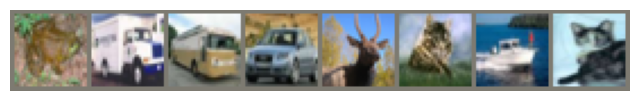

frog truck truck automobile deer cat ship cat


In [3]:
# Proper unnormalize function for CIFAR-10 (for any dataset the mean and std values should be changed accordingly)
def unnormalize(img, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)):
    """
    Undo normalization for an image tensor.

    Args:
        img (Tensor): Normalized image tensor (C, H, W).
        mean (tuple): Mean values used for normalization.
        std (tuple): Std values used for normalization.

    Returns:
        Tensor: Unnormalized image tensor.
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean

def imshow(img, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)):
    """
    Display an image or a grid of images after reversing normalization.

    Args:
        img (Tensor): Normalized image tensor (C, H, W) or a batch/grid.
        mean (tuple): Channel-wise mean used for normalization.
        std (tuple): Channel-wise std used for normalization.
    """
    # If batch/grid, unnormalize each image
    if img.ndim == 4:  # grid of images
        img = torch.stack([unnormalize(i, mean, std) for i in img])
        img = torchvision.utils.make_grid(img)
    else:
        img = unnormalize(img, mean, std)

    npimg = img.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(8, 8))
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()


# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))


## 4. Define Custom CNN Model
We will define a CNN with:
- Convolutional layers
- Batch Normalization
- Dropout for regularization
- Fully connected layers

In [4]:
class CNNModel(nn.Module):
    """
    Convolutional Neural Network for CIFAR-10 classification.
    Includes convolution, batch normalization, dropout, and fully connected layers.
    """
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(8 * 8 * 128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        """
        Forward pass of the model.
        
        Args:
            x (Tensor): Input tensor of shape (batch_size, 3, 32, 32).
            
        Returns:
            Tensor: Output logits of shape (batch_size, num_classes).
        """
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

print(model)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_fea

In [5]:
total_params = sum(p.numel() for p in model.parameters())

print(total_params)

2193674


## 5. Define Loss Function and Optimizer
We will use:
- **CrossEntropyLoss** for multi-class classification
- **Adam optimizer** with weight decay (L2 regularization)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

## 6. Train the Model


In [7]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    """
    Train the CNN model on CIFAR-10 dataset.
    
    Args:
        model (nn.Module): The CNN model.
        train_loader (DataLoader): DataLoader for training data.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        num_epochs (int): Number of epochs to train.
    """
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 1.7771
Epoch [2/10], Loss: 1.4568
Epoch [3/10], Loss: 1.3558
Epoch [4/10], Loss: 1.2830
Epoch [5/10], Loss: 1.2378
Epoch [6/10], Loss: 1.1967
Epoch [7/10], Loss: 1.1547
Epoch [8/10], Loss: 1.1068
Epoch [9/10], Loss: 1.0535
Epoch [10/10], Loss: 1.0030


## 7. Evaluate Model on Test Data


In [8]:
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test dataset.
    
    Args:
        model (nn.Module): Trained CNN model.
        test_loader (DataLoader): DataLoader for test data.
    
    Returns:
        float: Test accuracy.
    """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

test_accuracy = evaluate_model(model, test_loader)


Test Accuracy: 74.24%


## 8. Show Misclassified Images


In [9]:
def show_misclassified(model, test_loader, classes, mean=(0.4914, 0.4822, 0.4465),
                       std=(0.2023, 0.1994, 0.2010), num_images=8):
    """
    Display a few misclassified images from the test set with proper unnormalization.
    
    Args:
        model (nn.Module): Trained CNN model.
        test_loader (DataLoader): DataLoader for test data.
        classes (tuple): Tuple of class names.
        mean (tuple): Channel-wise mean used for normalization.
        std (tuple): Channel-wise std used for normalization.
        num_images (int): Number of misclassified images to display.
    """
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified.append((images[i].cpu(), predicted[i].cpu(), labels[i].cpu()))
                if len(misclassified) >= num_images:
                    break
            if len(misclassified) >= num_images:
                break

    plt.figure(figsize=(8, 4))
    for idx, (img, pred, true) in enumerate(misclassified):
        img = unnormalize(img, mean, std)  # proper unnormalize
        npimg = img.numpy().transpose((1, 2, 0))
        plt.subplot(2, num_images//2, idx+1)
        plt.imshow(npimg)
        plt.title(f"Pred: {classes[pred]}\nTrue: {classes[true]}")
        plt.axis("off")
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.9647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.9647059].


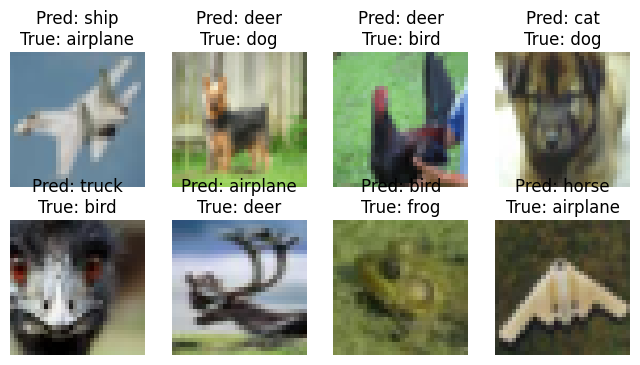

In [10]:
show_misclassified(model, test_loader, classes, num_images=8)

## 9. Save the Model


In [11]:
torch.save(model.state_dict(), "cnn_cifar10.pth")
print("Model saved as cnn_cifar10.pth")


Model saved as cnn_cifar10.pth


## 10. Load the Saved Model and Run Inference


In [12]:
# Re-initialize model structure
loaded_model = CNNModel().to(device)

# Load saved state_dict
loaded_model.load_state_dict(torch.load("cnn_cifar10.pth"))

# Set to evaluation mode
loaded_model.eval()

print("Model loaded successfully and ready for inference.")


Model loaded successfully and ready for inference.


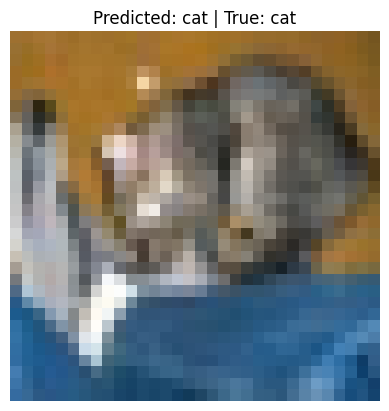

In [13]:
# Inference on a single test image
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Select one image
idx = 0
image = images[idx].unsqueeze(0).to(device)  # add batch dimension
label = labels[idx]

# Run through the model
with torch.no_grad():
    outputs = loaded_model(image)
    _, predicted = torch.max(outputs, 1)

# Show the image and prediction
img_to_show = images[idx]
img = unnormalize(img_to_show) # unnormalize
npimg = img.numpy().transpose((1, 2, 0))

plt.imshow(npimg)
plt.title(f"Predicted: {classes[predicted.item()]} | True: {classes[label.item()]}")
plt.axis("off")
plt.show()
